In [1]:
using Pandas
using DataFrames
using PyCall
using PyPlot
using CSV
using LsqFit
using Printf
using KernelDensity
using Distributions

include("tacos.jl") # Tools to Analyse Components Systems
using Main.Tacos

scipy_integrate = pyimport("scipy.integrate")
scipy_stats = pyimport("scipy.stats")
pushfirst!(PyVector(pyimport("sys")."path"), "")
frontiers = pyimport("frontiers_colors");

# Global Zipf 

In [8]:
f_gtex = CSV.read("A_gtex.dat", header=true).abundance
f_gtex = sort(f_gtex./sum(f_gtex), rev=true);

┌ Warning: `CSV.read(input; kw...)` is deprecated in favor of `using DataFrames; CSV.read(input, DataFrame; kw...)
│   caller = ip:0x0
└ @ Core :-1


In [9]:
f_mca = load_pickle("mca/data_all.pkl")["freq"]
f_mca = sort(f_mca./sum(f_mca), rev=true);

In [10]:
f_tm = load_pickle("tm/data_all.pkl")["freq"]
f_tm = sort(f_tm./sum(f_tm), rev=true);

In [11]:
fig, ax = PyPlot.subplots(figsize=(18,15))

X = collect(1:1e5)

#ax.plot(X,[1e-1*x^-0.86 for x in X], lw=20, ls="--", color="gray")
ax.plot(X[1:50],[1e-2*x^-0.5 for x in X[1:50]], lw=20, ls="--", color="darkgray")
ax.plot(X[50:3400],[1e-1*x^-0.86 for x in X[50:3400]], lw=20, ls="--", color="gray")
ax.plot(X[3400:end],[9.6434421e-5*exp(-x*0.00024068098160088248) for x in X[3400:end]], lw=20, ls="--", color="gray")


ax.plot(f_gtex, label="GTEx", lw=15, color="gray", alpha=0.7)
ax.plot(f_mca, label="Mouse Cell Atlas", lw=15, color="blue", alpha=0.6)
ax.plot(f_tm, label="Tabula Muris", lw=15, color="red", alpha=0.5)

ax.vlines([limits[1]], 1e-9, 1e-1, colors="gray", ls="-.", lw=10, alpha =0.5)
ax.vlines([limits[2]], 1e-9, 1e-1, colors="gray", ls="-.", lw=10, alpha =0.5)

ax.annotate(L"$k*i^{-0.5}$", (3e0,0.5e-4), fontsize=35)
ax.annotate(L"$k*i^{-0.8}$", (2e2,0.5e-4), fontsize=35)
ax.annotate(L"$k*e^{-0.002*x}$", (0.8e4,0.5e-4), fontsize=35)

ax.annotate("$(limits[1])", (limits[1],2e-9), fontsize=35, alpha=0.8)
ax.annotate("$(limits[2])", (limits[2],2e-9), fontsize=35, alpha=0.8)

ax.legend(fontsize=35)
ax.set_yscale("log")
ax.set_xscale("log")

ax.tick_params(labelsize=35, width=8, length=20)
ax.tick_params(axis="both",which="minor", width=5, length=10)

ax.set_xlabel(L"Rank, $i$", fontsize=35)
ax.set_ylabel(L"Frequency, $f_i$", fontsize=35)

ax.set_xlim(1,1e5)
ax.set_ylim(1e-9,1e0)
show()

fig.savefig("zipf_alldatasets.pdf")


UndefVarError: UndefVarError: limits not defined

## Fit ranges

In [7]:
fit_func = function(X, p)
    return p[1]*[x^(-p[2]) for x in X]
end

fit_func_exp = function(X, p)
    return p[1]*[exp(-p[2]*x) for x in X]
end

#13 (generic function with 1 method)

In [ ]:
bounds = Dict()

bounds["dx"] = Dict()
bounds["sx"] = Dict()

bounds["sx"]["min"]=2
bounds["sx"]["max"]=122
bounds["sx"]["step"]=10

bounds["dx"]["min"]=5e2
bounds["dx"]["max"]=2e4
bounds["dx"]["step"]=100

optimize_fit = function(f)
    maxmimum_r2 = -Inf
    optimal_fit = nothing
    optimal_limits = nothing
    fit_exp = nothing
    
    Rs = zeros(Float64, Int64((bounds["sx"]["max"]- bounds["sx"]["min"])/ bounds["sx"]["step"]+1), Int64(( bounds["dx"]["max"]- bounds["dx"]["min"])/ bounds["dx"]["step"]+1))
    for left_side::Int32=range(bounds["sx"]["min"],bounds["sx"]["max"],step=bounds["sx"]["step"]), right_side::Int32=range(bounds["dx"]["min"],bounds["dx"]["max"],step=bounds["dx"]["step"])
        #println(left_side," ", right_side)
        
        x_data = left_side:right_side
        y_data = f[left_side:right_side]
        fit = curve_fit(fit_func, x_data, y_data, [1e-1, 0.8])
        popt, pcov = (coef(fit), estimate_covar(fit))
        r_squared = estimate_r2(fit_func, popt, x_data, y_data)
        Rs[Int64((left_side-bounds["sx"]["min"])/bounds["sx"]["step"]+1),Int64((right_side-bounds["dx"]["min"])/bounds["dx"]["step"]+1)]=r_squared
        if r_squared > maxmimum_r2
            maxmimum_r2 = r_squared
            optimal_fit = fit
            optimal_limits = (left_side, right_side)
        end    
    end
    return maxmimum_r2, optimal_fit, optimal_limits, Rs, bounds
end

In [ ]:
r2, fit,  limits, Rs, windows = optimize_fit(f_gtex);

In [ ]:
fig, ax = PyPlot.subplots(figsize=(18,15))

popt = coef(fit)

ax.plot(f_gtex, label="GTEx", lw=15, color="gray", alpha=0.7)
ax.plot(f_mca, label="Mouse Cell Atlas", lw=15, color="blue", alpha=0.6)
ax.plot(f_tm, label="Tabula Muris", lw=15, color="red", alpha=0.5)

X = collect(1:1e5)

#ax.plot(X,[1e-1*x^-0.8 for x in X], ls="--", color="gray")
ax.plot(X,[popt[1]*x^-popt[2] for x in X], ls=":", lw=5, color="green", label="$(@sprintf("%.2f", popt[1]))*x^-$(@sprintf("%.2f", popt[2]))")

#ax.annotate(L"$k*i^{-0.8}$", (1e2,1e-2), fontsize=22)
ax.annotate("R^2=$(@sprintf("%.4f", r2))", (10^((log10(limits[1])+log10(limits[2]))/2),1e-6), fontsize=35)

ax.vlines([limits[1] limits[2]], 1e-9, 1e-1, colors="gray", ls="-.", lw=15, alpha =0.5)
ax.annotate("$(limits[1])", (limits[1],2e-9), fontsize=35, alpha=0.8)
ax.annotate("$(limits[2])", (limits[2],2e-9), fontsize=35, alpha=0.8)


ax.legend(fontsize=35)
ax.set_yscale("log")
ax.set_xscale("log")

ax.set_xlabel(L"Rank, $i$", fontsize=35)
ax.set_ylabel(L"Frequency, $f_i$", fontsize=35)

ax.tick_params(labelsize=35, width=8, length=20)


ax.set_xlim(1,1e5)
ax.set_ylim(1e-9,1e0)
show()

fig.savefig("zipf_alldatasets_fit_gtex.pdf")

In [ ]:
CSV.write("rs_gtex.csv", DataFrames.DataFrame(Rs))

In [ ]:
fig,ax = PyPlot.subplots(1, 2, figsize=(18,8))

for (dataset, limits, sx_max, color) in zip(["tm", "mca", "gtex"],[(12,1000); (72,4100); (62,5100)],[82 122 122], ["red" "blue" "gray"])
    Rs = Matrix(CSV.read("rs_$(dataset).csv"))
    ax[1].plot(range(bounds["sx"]["min"],sx_max-1,step=bounds["sx"]["step"]), Rs[:,Int64((limits[2]-bounds["dx"]["min"])/bounds["dx"]["step"]+1)], lw=15, color=color)
    ax[2].plot(range(bounds["dx"]["min"],bounds["dx"]["max"],step=bounds["dx"]["step"]), Rs[Int64((limits[1]-bounds["sx"]["min"])/bounds["sx"]["step"]+1),:], lw=15, color=color)
        
    ax[1].vlines([limits[1]], 0.95, 1, colors=color, ls="-.", lw=10, alpha =0.5)
    ax[2].vlines([limits[2]], 0.98, 1, colors=color, ls="-.", lw=10, alpha =0.5)
end

ax[1].set_ylabel(L"R^2", fontsize=35)
ax[1].set_xlabel("left bound", fontsize=35)
#ax[1].set_xscale("log")

ax[2].set_xlabel("right bound", fontsize=35)
#ax[2].set_xscale("log")

ax[1].tick_params(axis="x", rotation=10)
ax[2].tick_params(axis="x", rotation=10)
#ax[2].set_ylim(0.98,0.999)

PyPlot.show()
fig.savefig("bounds.pdf")

In [ ]:
fig,ax = PyPlot.subplots(3, 2, figsize=(18,24))

for ((idataset,dataset), limits, sx_max, color) in zip(enumerate(["tm", "mca", "gtex"]),[(12,1000); (72,4100); (62,5100)],[82 122 122], ["red" "blue" "gray"])
    Rs = Matrix(CSV.read("rs_$(dataset).csv"))
    
    lax = idataset
    rax= idataset+3
    
    ax[lax].plot(range(bounds["sx"]["min"],sx_max,step=bounds["sx"]["step"]), Rs[:,Int64((limits[2]-bounds["dx"]["min"])/bounds["dx"]["step"]+1)], lw=15, color=color)
    ax[rax].plot(range(bounds["dx"]["min"],bounds["dx"]["max"],step=bounds["dx"]["step"]), Rs[Int64((limits[1]-bounds["sx"]["min"])/bounds["sx"]["step"]+1),:], lw=15, color=color)
    
    ax[lax].vlines([limits[1]], 0.95, 1, colors=color, ls="-.", lw=10, alpha =0.5)
    ax[rax].vlines([limits[2]], 0.98, 1, colors=color, ls="-.", lw=10, alpha =0.5)
    
    ax[lax].set_ylabel(L"R^2", fontsize=35)

    ax[rax].set_xscale("log")
    
    ax[lax].tick_params(axis="x", rotation=10)
    ax[lax].tick_params(axis="x", rotation=10)
    
    ax[lax].tick_params(labelsize=35, width=8, length=20)
    ax[lax].tick_params(axis="both", which="minor", width=5, length=10)
    
    ax[rax].tick_params(labelsize=35, width=8, length=20)
    ax[rax].tick_params(axis="both", which="minor", width=5, length=10)

end

ax[3].set_xlabel("left bound", fontsize=35)
ax[6].set_xlabel("right bound", fontsize=35)

ax[1].set_title("Tabula Muris", fontsize=35)
ax[2].set_title("Mouse Cell Atlas", fontsize=35)
ax[3].set_title("GTEx", fontsize=35)


ax[1].set_ylim(0.99,1)
ax[4].set_ylim(0.98,1)
ax[5].set_ylim(0.9950,1)


PyPlot.show()
fig.savefig("bounds_panel.pdf")

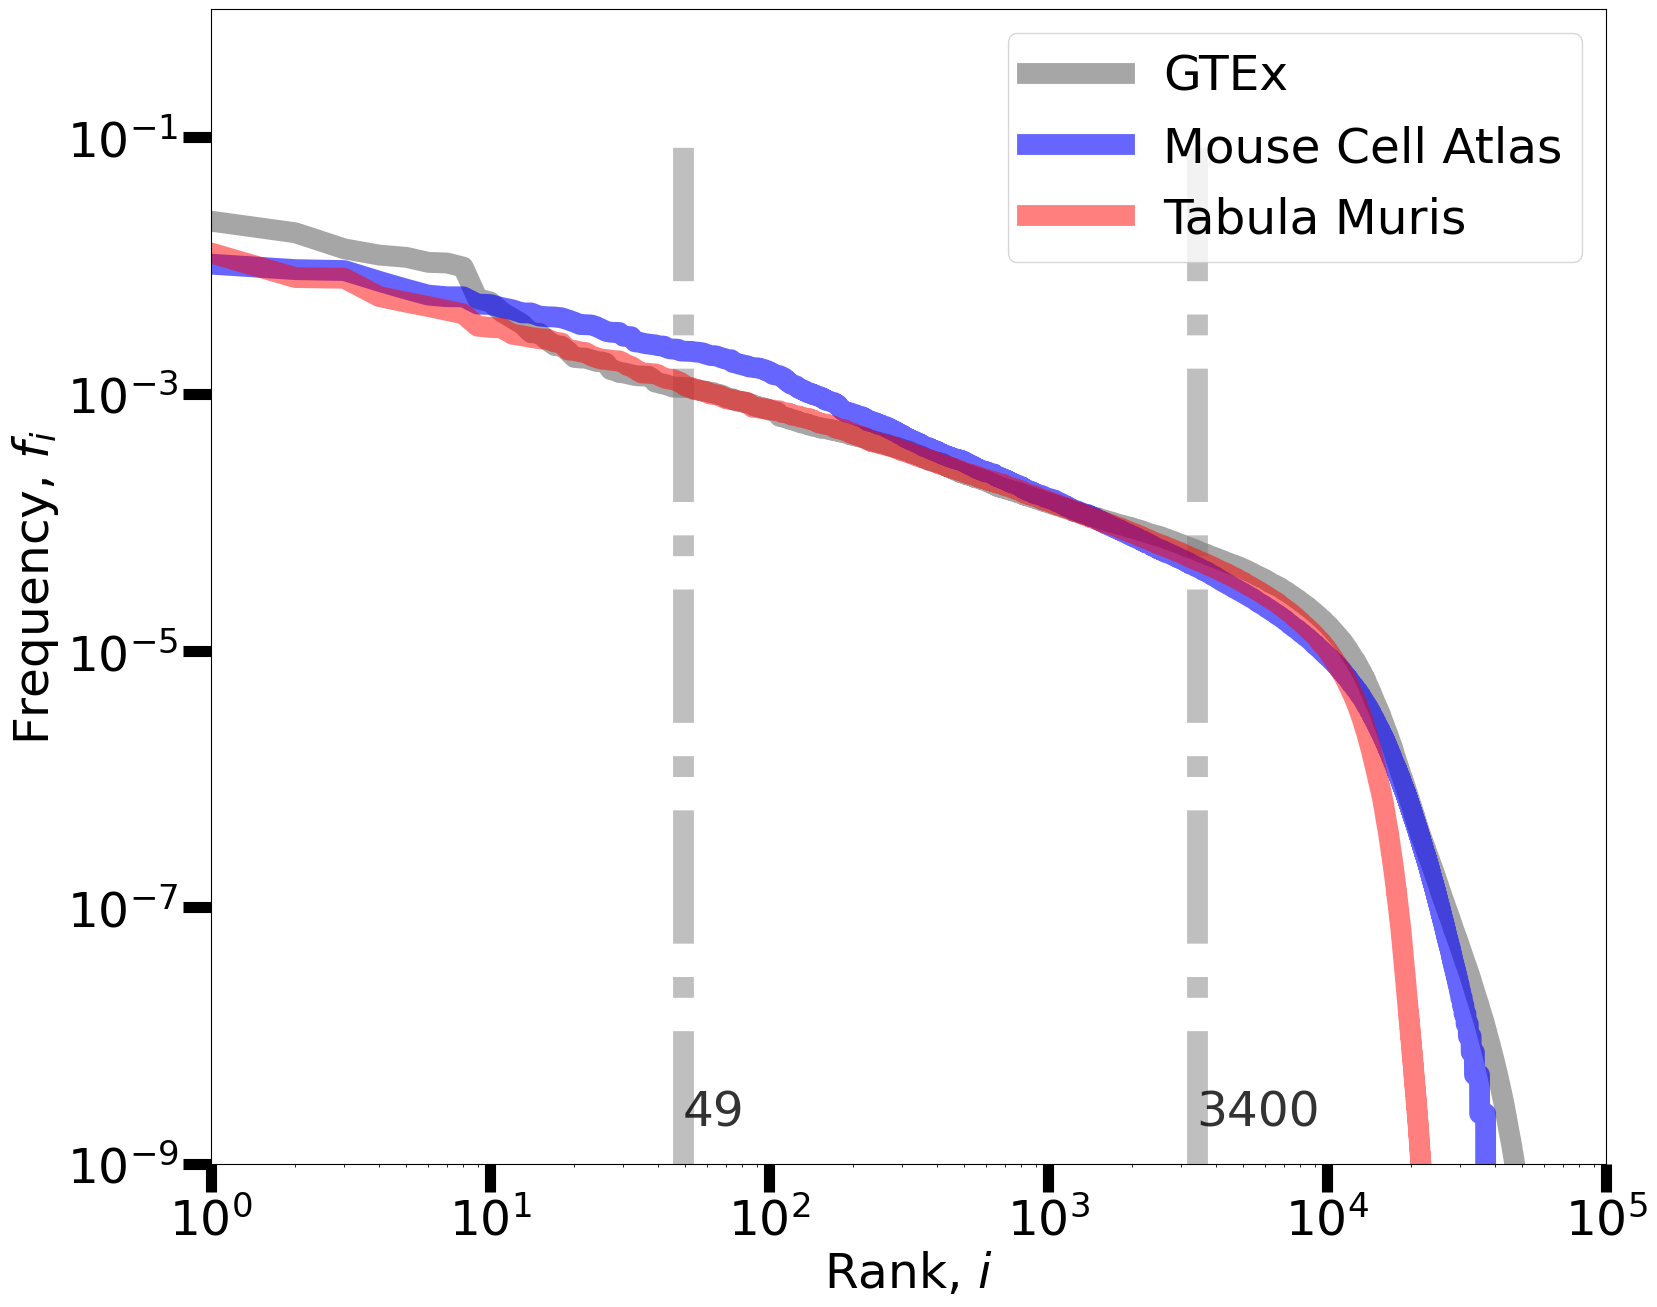

In [17]:
limits = (Int64(round(mean([12 72 62]))), Int64(round(mean([1000 4100 5100])))) #tm mca gtex

fig, ax = PyPlot.subplots(figsize=(18,15))

ax.plot(f_gtex, label="GTEx", lw=15, color="gray", alpha=0.7)
ax.plot(f_mca, label="Mouse Cell Atlas", lw=15, color="blue", alpha=0.6)
ax.plot(f_tm, label="Tabula Muris", lw=15, color="red", alpha=0.5)

X = collect(1:1e5)

ax.vlines([limits[1] limits[2]], 1e-9, 1e-1, colors="gray", ls="-.", lw=15, alpha =0.5)
ax.annotate("$(limits[1])", (limits[1],2e-9), fontsize=35, alpha=0.8)
ax.annotate("$(limits[2])", (limits[2],2e-9), fontsize=35, alpha=0.8)


ax.legend(fontsize=35)
ax.set_yscale("log")
ax.set_xscale("log")

ax.set_xlabel(L"Rank, $i$", fontsize=35)
ax.set_ylabel(L"Frequency, $f_i$", fontsize=35)

ax.tick_params(labelsize=35, width=8, length=20)

ax.set_xlim(1,1e5)
ax.set_ylim(1e-9,1e0)
show()

fig.savefig("zipf_alldatasets_fit_avg.pdf")

In [18]:
fit = curve_fit(fit_func_exp, X[3400:length(f_mca)], f_mca[3400:end], [1e-1, 1e-3])
popt_exp, pcov_exp = (coef(fit), estimate_covar(fit))

([9.643442170490089e-5, 0.00024068098160088248], [2.377266130146697e-15 3.9328487884125675e-15; 3.9328487884125675e-15 7.444143657137285e-15])

Download *MGImarkerQuery_20200914_050053.txt* from (http://www.informatics.jax.org/marker)[http://www.informatics.jax.org/marker]

In [13]:
df_nc = CSV.read("MGImarkerQuery_20200914_050053.txt", delim="\t");
names(df_nc)

thread = 1 warning: only found 10 / 11 columns around data row: 2. Filling remaining columns with `missing`
thread = 1 warning: only found 10 / 11 columns around data row: 3. Filling remaining columns with `missing`
thread = 1 warning: only found 10 / 11 columns around data row: 4. Filling remaining columns with `missing`
thread = 1 warning: only found 10 / 11 columns around data row: 5. Filling remaining columns with `missing`
thread = 1 warning: only found 10 / 11 columns around data row: 2. Filling remaining columns with `missing`
thread = 1 warning: only found 10 / 11 columns around data row: 3. Filling remaining columns with `missing`
thread = 1 warning: only found 10 / 11 columns around data row: 4. Filling remaining columns with `missing`
thread = 1 warning: only found 10 / 11 columns around data row: 5. Filling remaining columns with `missing`
thread = 1 warning: only found 10 / 11 columns around data row: 6. Filling remaining columns with `missing`
thread = 1 warning: only fou

Excessive output truncated after 524355 bytes.

thread = 1 warning: only found 10 / 11 columns around data row: 4674. Filling remaining columns with `missing`
thread = 1 warning: only found 10 / 11 columns around data row: 4675. Filling remaining columns with `missing`
thread = 1 warning: only found 10 / 11 columns around data row: 4676. Filling remaining columns with `missing`
thread = 1 warning: only found 10 / 11 columns around data row: 4677. Filling remaining columns with `missing`
thread = 1 warning: only found 10 / 11 columns around data row: 4678. Filling remaining columns with `missing`
thread = 1 warning: only found 10 / 11 columns around data row: 4679. Filling remaining columns with `missing`
thread = 1 warning: only found 10 / 11 columns around data row: 4680. Filling remaining columns with `missing`
thread = 1 warning: only found 10 / 11 columns around data row: 4681. Filling remaining columns with `missing`
thread = 1 warning: only found 10 / 11 columns around data row: 4682. Filling remaining columns with `missing`
t

11-element Array{String,1}:
 "Chromosome"
 "Start"
 "End"
 "cM"
 "strand GRCm38"
 "MGI ID"
 "Feature Type"
 "Symbol"
 "Name"
 "Column10"
 "Column11"

In [14]:
nc = df_nc[df_nc[:,"Feature Type"] .!= "protein coding gene","Symbol"];

In [19]:
f_mca = load_pickle("mca/data_all.pkl")["freq"]
mask = reshape(1 .- f_mca.index.isin(nc),(length(f_mca)))
f_mca_pc = [v for v in f_mca][mask .== 1];
f_mca_pc = sort(f_mca_pc./sum(f_mca_pc), rev=true);
f_mca = sort(f_mca./sum(f_mca), rev=true);

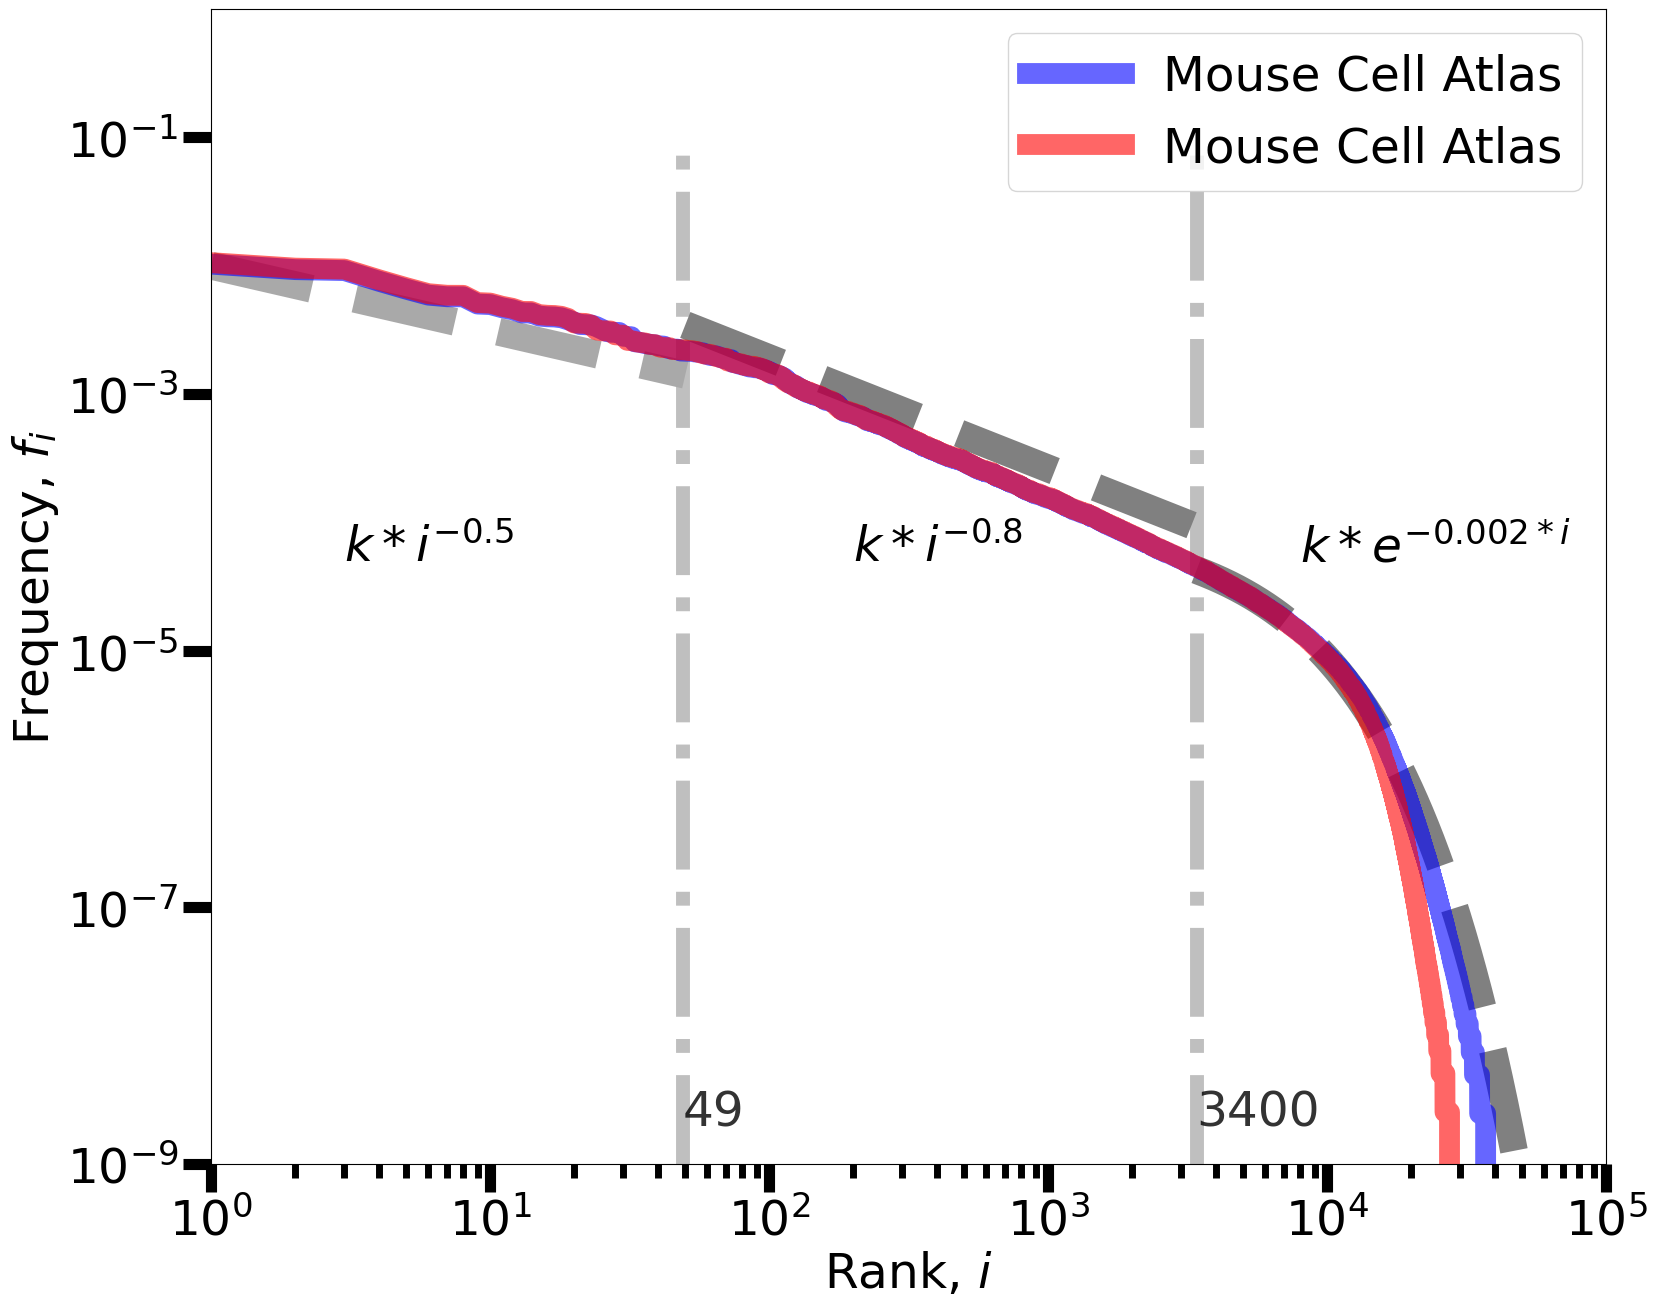

In [25]:
fig, ax = PyPlot.subplots(figsize=(18,15))

X = collect(1:1e5)

#ax.plot(X,[1e-1*x^-0.86 for x in X], lw=20, ls="--", color="gray")
ax.plot(X[1:50],[1e-2*x^-0.5 for x in X[1:50]], lw=20, ls="--", color="darkgray")
ax.plot(X[50:3400],[1e-1*x^-0.86 for x in X[50:3400]], lw=20, ls="--", color="gray")
ax.plot(X[3400:end],fit_func_exp(X[3400:end], popt_exp), lw=20, ls="--", color="gray")


#ax.plot(f_gtex, label="GTEx", lw=15, color="gray", alpha=0.7)
ax.plot(f_mca, label="Mouse Cell Atlas", lw=15, color="blue", alpha=0.6)
ax.plot(f_mca_pc, label="Mouse Cell Atlas", lw=15, color="red", alpha=0.6)
#ax.plot(f_tm, label="Tabula Muris", lw=15, color="red", alpha=0.5)

ax.vlines([limits[1]], 1e-9, 1e-1, colors="gray", ls="-.", lw=10, alpha =0.5)
ax.vlines([limits[2]], 1e-9, 1e-1, colors="gray", ls="-.", lw=10, alpha =0.5)

ax.annotate(L"$k*i^{-0.5}$", (3e0,0.5e-4), fontsize=35)
ax.annotate(L"$k*i^{-0.8}$", (2e2,0.5e-4), fontsize=35)
ax.annotate(L"$k*e^{-0.002*i}$", (0.8e4,0.5e-4), fontsize=35)

ax.annotate("$(limits[1])", (limits[1],2e-9), fontsize=35, alpha=0.8)
ax.annotate("$(limits[2])", (limits[2],2e-9), fontsize=35, alpha=0.8)

ax.legend(fontsize=35)
ax.set_yscale("log")
ax.set_xscale("log")

ax.tick_params(labelsize=35, width=8, length=20)
ax.tick_params(axis="both",which="minor", width=5, length=10)

ax.set_xlabel(L"Rank, $i$", fontsize=35)
ax.set_ylabel(L"Frequency, $f_i$", fontsize=35)

ax.set_xlim(1,1e5)
ax.set_ylim(1e-9,1e0)
show()

fig.savefig("zipf_mca.pdf")

### Save first regime for GO

In [ ]:
first_regime = DataFrames.DataFrame()
first_regime.mca = sort(CSV.read("A_mca.dat"), 2, rev=true).Column1[1:limits[1]]
first_regime.tm = sort(CSV.read("A_tm.dat"), 2, rev=true).Column1[1:limits[1]]
first_regime.gtex = sort(CSV.read("A_gtex.dat"), 2, rev=true).ensg[1:limits[1]]
CSV.write("first_regime.csv",first_regime)

first_common = first_regime
filter(isin, first_regime.mca)

# Global scaling

## Var vs Mean

In [ ]:
data_source = "mca"
data = load_pickle("$(data_source)/data_all.pkl");

In [ ]:
fig, ax = PyPlot.subplots(figsize=(18,15))

ax.scatter(data["means"], data["var"], c="gray", s=225, alpha=0.3, label="data")

x = range(1e-5,10, length=10)
ax.plot(x,x, lw=5, color="red", ls="--", label=L"$m_g$ (Poisson)")

x = range(0.5,5e5, length=10)
ax.plot(x,[x_i^2 for x_i in x], lw=5, color="blue", ls="--", label=L"$m_g^2$ (Taylor)")

ax.set_xlabel(L"Mean expression level, $m_g$", fontsize=35)
ax.set_ylabel(L"Variance of expression level, $v_g$", fontsize=35)

ax.set_xscale("log")
ax.set_yscale("log")

ax.tick_params(labelsize=35, width=8, length=20)

ax.set_xlim(1e-5, data["means"].max()*1.5)
ax.set_ylim(1e-6, data["var"].max()*1.5)

ax.legend(fontsize=35)

PyPlot.show()
fig.savefig("var_mean_$(data_source).pdf")

## CV2 mean

In [ ]:
fig, ax = PyPlot.subplots(figsize=(18,15))

means = [m for (m,v) in zip(data["means"], data["var"]) if v>1e-6]
vars = [v for v in data["var"] if v>1e-6]

ax.scatter(means, [v/m/m for (m,v) in zip(means, vars)], c="gray", alpha=0.3, s=225, label="data")

x = range(1e-5,10, length=10)
ax.plot(x,[1/x_i for x_i in x], lw=5, color="red", ls="--", label=L"$m_g^{-1}$ (Poisson)")

x = range(0.5,5e5, length=10)
ax.plot(x,[1 for _ in x], lw=5, color="blue", ls="--", label=L"$1$ (Taylor)")

ax.set_ylabel(L"Coefficient of variation squared, $CV^2_g$", fontsize=35)
ax.set_xlabel(L"Mean expression level, $m_g$", fontsize=35)

ax.set_xscale("log")
ax.set_yscale("log")

ax.tick_params(labelsize=35, width=8, length=20)

ax.set_xlim(1e-5, maximum(means)*1.5)
ax.set_ylim(5e-2, 1e5)

ax.legend(fontsize=35)

PyPlot.show()
fig.savefig("cv2_mean_$(data_source).pdf")

# Histogram of all data

In [18]:
data_source= "mca"
n_bins=50

bin_counts=zeros(n_bins)
bin_edges = zeros(n_bins+1)

bin_pdf = zeros(n_bins)

for tissue in [f for f in readdir("$(data_source)") if occursin("mainTable",f)]
    if !(split(split(tissue,"_")[2],".")[1] in ["Brain" "Liver" "Muscle" "Bladder" "Prostate" "Kidney" "Ovary" "Uterus" "Lung"])
        continue
    end
    if occursin("Marrow.csv", tissue)
        continue
    end
    if occursin("Neonatal", tissue)
        continue
    end
    if occursin("Mammary", tissue)
        continue
    end
    if occursin("Fetal", tissue)
        continue
    end
    if occursin("Embryonic", tissue)
        continue
    end
    if occursin("Mesenchym", tissue)
        continue
    end
    println(tissue)
    df = CSV.read("$(data_source)/$(tissue)");
    df_values = convert(Array, select!(df,Not(1)));
    df_values=df_values./sum(df_values, dims = 1)
    df_values = reshape(df_values,1,size(df_values)[1]*size(df_values)[2])
    df_values = df_values[df_values.>0]
    x=[log2(dge) for dge in df_values];
    #bc, be = ax.hist(x, lw=10, histtype="step", density=false, bins = n_bins)
    bc, be,_ = scipy_stats.binned_statistic(x, values = [1 for _ in x], bins=n_bins, statistic = "count")
    bin_counts+=bc
    x_bins = (be[2:length(be)] + be[1:length(be)-1])/2
    bin_pdf += pdf(kde(x), x_bins)
    bin_edges=be
end
GC.gc()

mainTable_Bladder.csv
mainTable_Brain.csv
mainTable_Kidney.csv
mainTable_Liver.csv
mainTable_Lung.csv
mainTable_Muscle.csv
mainTable_Ovary.csv
mainTable_Prostate.csv
mainTable_Uterus.csv


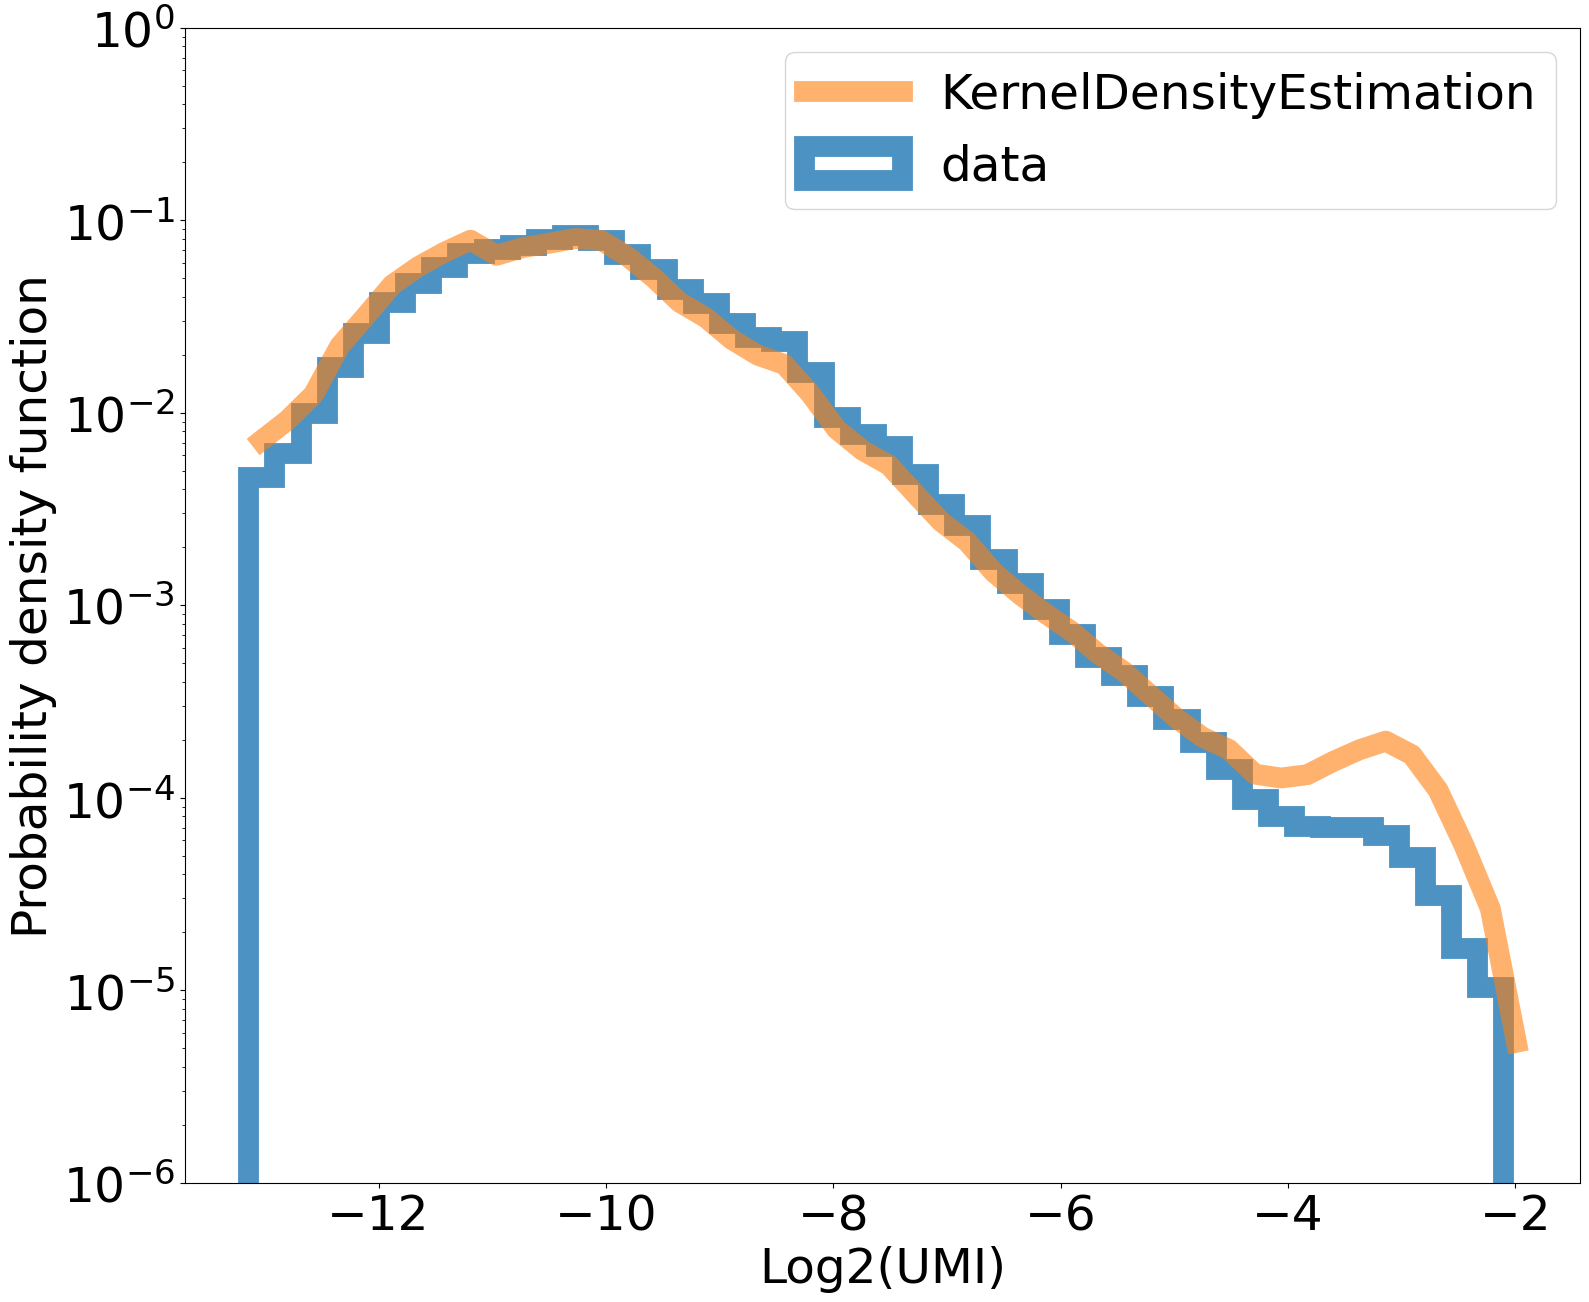

In [19]:
fig, ax = PyPlot.subplots(figsize=(18,15))


#bin_count, bin_edges = ax.hist(x, lw=10, histtype="step", density=true, bins = 20)

x_bins = (bin_edges[2:length(bin_edges)]+ bin_edges[1:length(bin_edges)-1])/2

rang = 2:n_bins
ax.hist(bin_edges[2:length(bin_edges)-1], bins=bin_edges[2:length(bin_edges)-1], weights=bin_counts[rang] / sum(bin_counts[rang]), histtype="step", lw=15, alpha=0.8, label="data")

ax.plot(x_bins[rang], bin_pdf[rang] / sum(bin_pdf[rang]), lw=15, alpha=0.6, label="KernelDensityEstimation")

ax.set_xlabel("Log2(UMI)", fontsize=35)
ax.set_ylabel("Probability density function", fontsize=35)

ax.set_yscale("log")
ax.set_ylim(1e-6,1)

ax.tick_params(labelsize=35)

ax.legend(fontsize=35)
PyPlot.show()

fig.savefig("all_hist_$(data_source)_norm.pdf")
fig.savefig("all_hist_$(data_source)_norm.png", dpi=400)

# Global U

In [ ]:
data = load_pickle("mca/data_all.pkl");

In [ ]:
fig, ax = PyPlot.subplots(figsize=(18,15))

bins = -0.05:0.1:1.05

bin_counts, bin_edges = ax.hist(data["O"].values[data["O"].index.isin(CSV.read("tm/mainTable_Aorta-counts.csv.csv").Column1)], color="blue", lw=10, histtype="step", bins=bins)

x_bins = (bin_edges[1:length(bin_edges)-1]+bin_edges[2:length(bin_edges)])/2
ax.hist(x_bins, weights=bin_counts, bins=bins, histtype="stepfilled", lw=0, alpha=0.8)

ax.set_xlabel(L"Occurrence, O_i", fontsize=35)
ax.set_ylabel("Number of genes", fontsize=35)

ax.tick_params(labelsize=35, width=8, length=20)
ax.tick_params(which="minor", width=6, length=10)

PyPlot.show()
fig.savefig("U_mca.pdf")

# Pdf of Frequencies

In [2]:
data = load_pickle("mca/data_all.pkl");

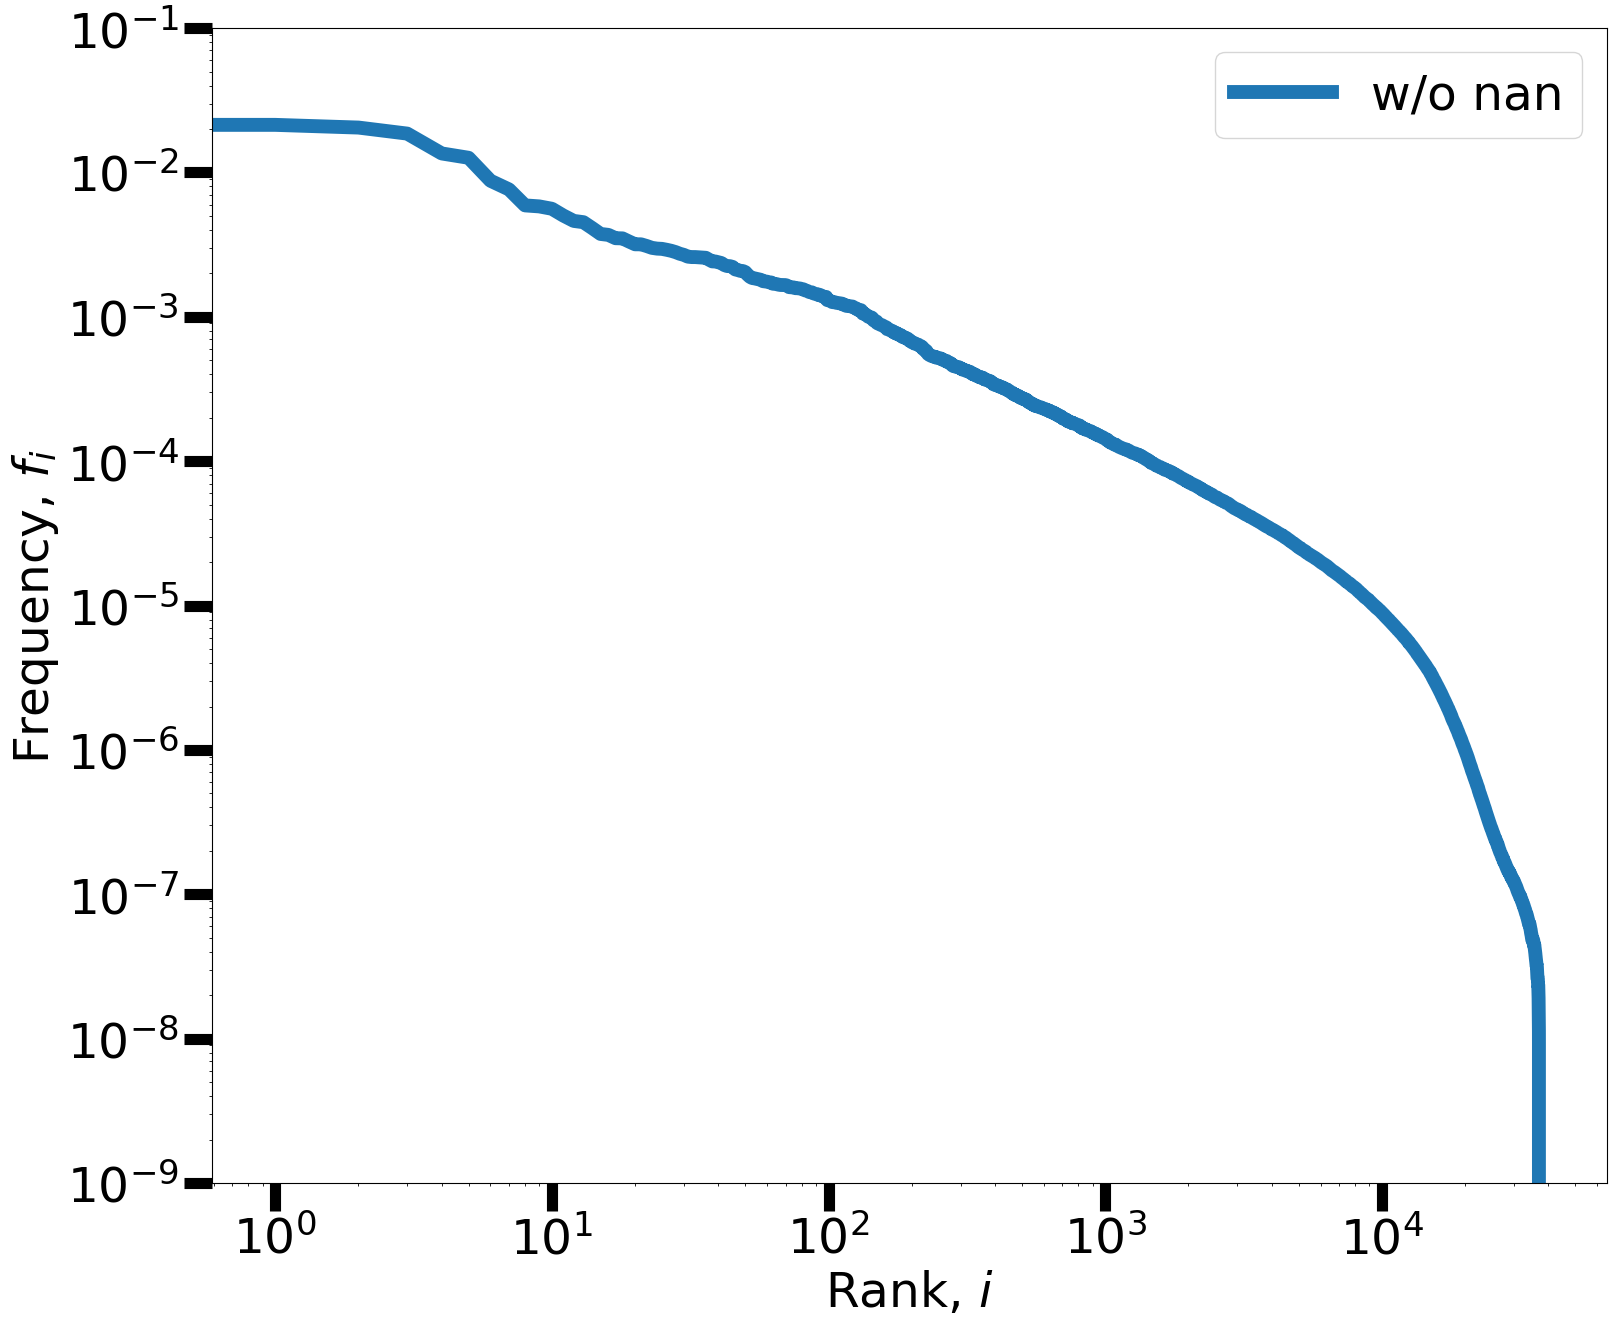

In [3]:
fig, ax = PyPlot.subplots(figsize=(18,15))


#ax.plot(sort!(data["freq"].values,rev=true), label="nan=0", lw=10)
ax.plot(sort!(data["means"].values/sum(filter(!isnan, data["means"].values)),rev=true), label="w/o nan", lw=10)
#ax.plot(sort!(data["means_nonzero"].values/sum(filter(!isnan, data["means_nonzero"].values)),rev=true), ms=50, label="m0", lw=10, color="gray")

ax.set_xscale("log")
ax.set_yscale("log")

ax.legend(fontsize=35)
ax.set_yscale("log")
ax.set_xscale("log")

ax.set_ylim(1e-9,1e-1)

ax.tick_params(labelsize=35, width=8, length=20)
ax.set_xlabel(L"Rank, $i$", fontsize=35)
ax.set_ylabel(L"Frequency, $f_i$", fontsize=35)
fig.savefig("pdf_freq_mca.pdf")

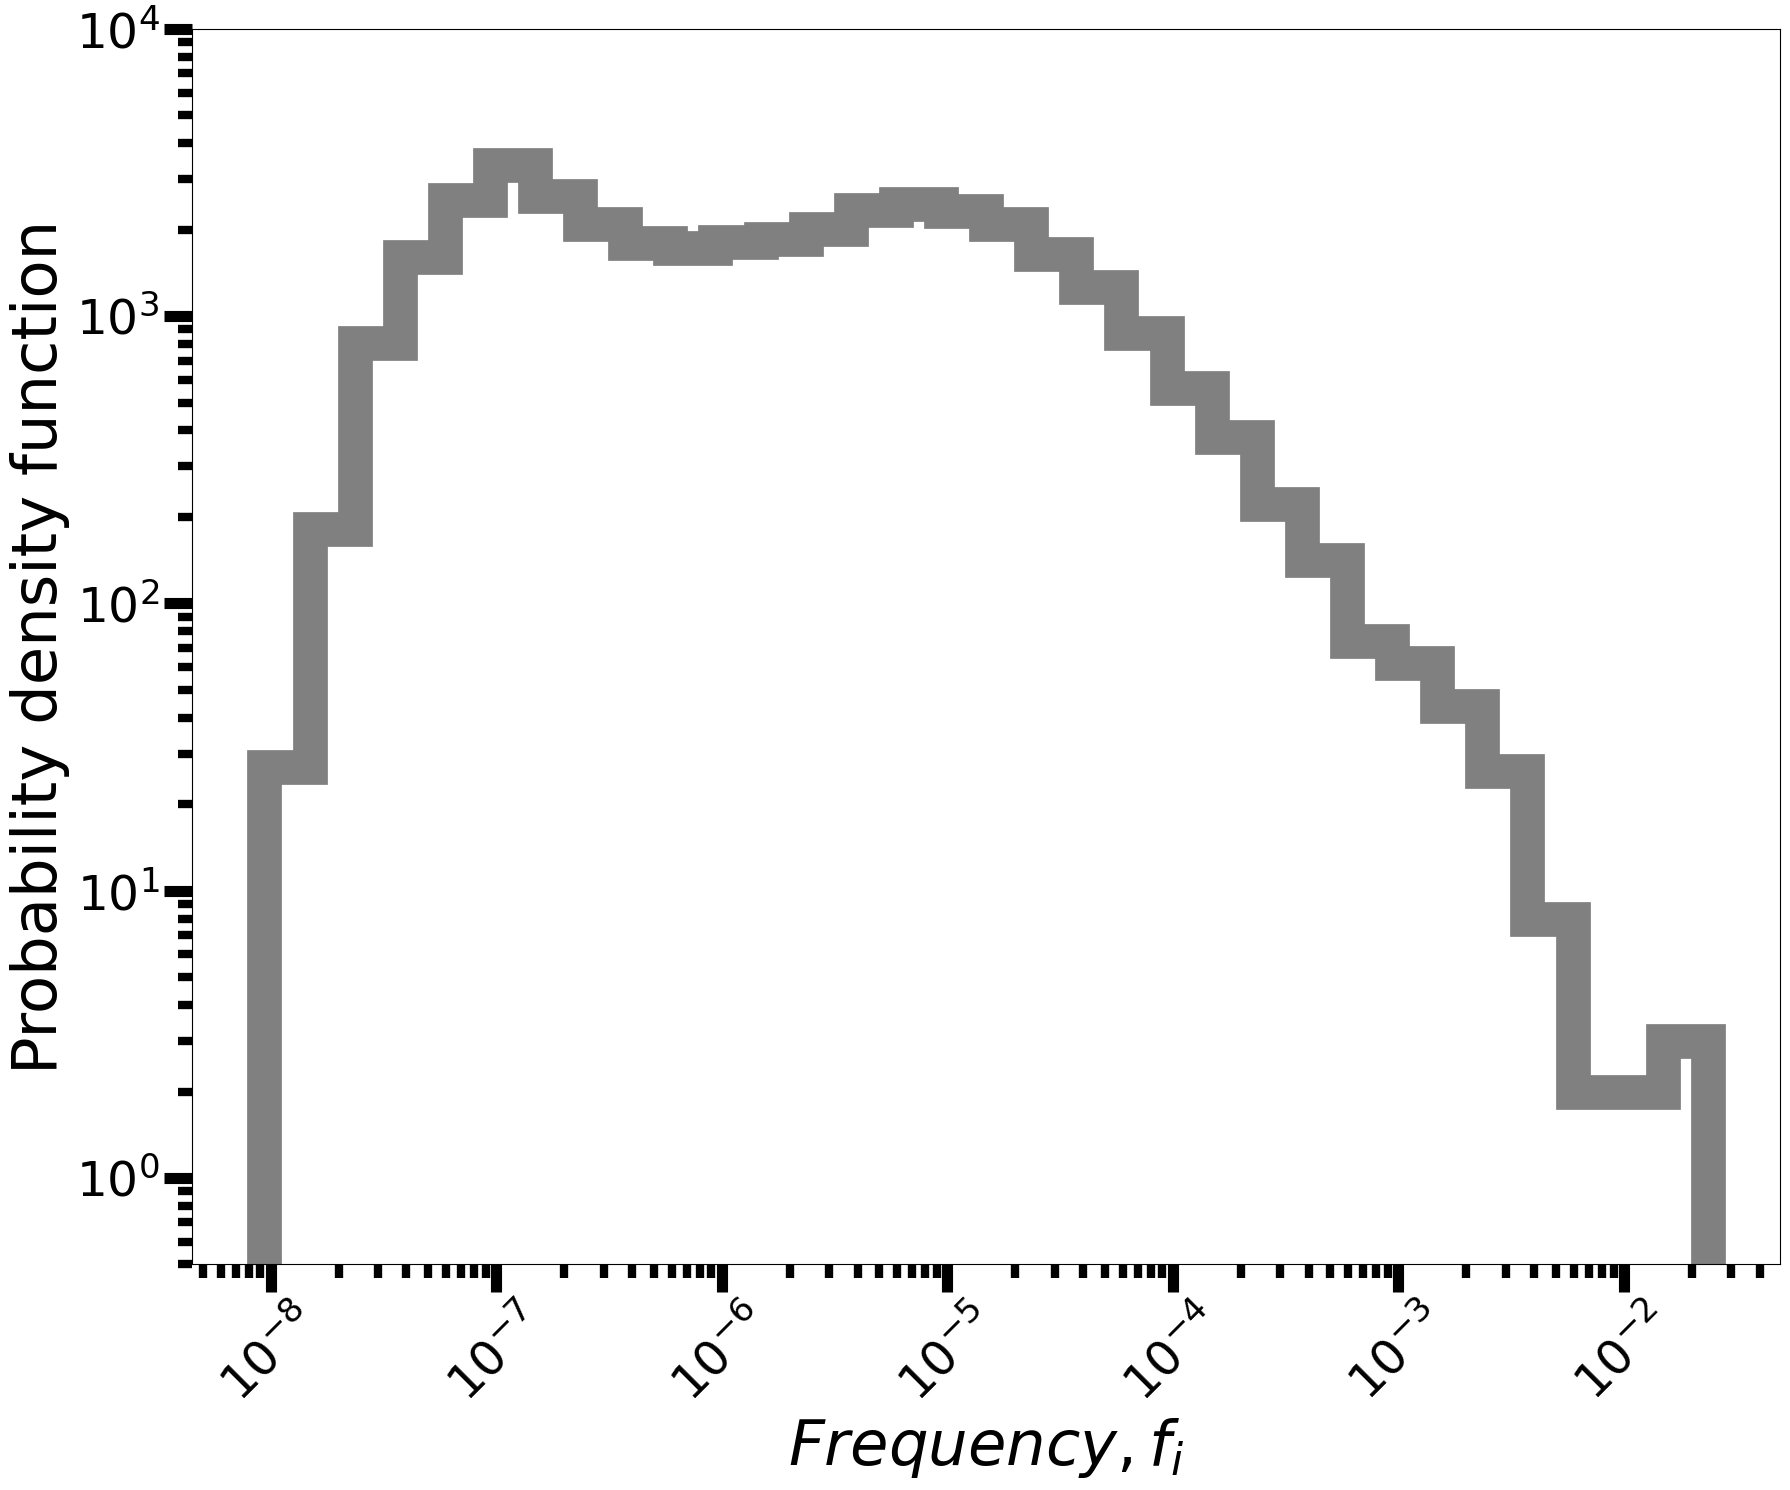

In [6]:
fig, ax = PyPlot.subplots(figsize=(18,15))

f = filter(!isnan, data["means"].values)
f = f / sum(f)
#f = data["freq"].values
f = f[f .> 0]
#f = f[f .< 5e-3]


#x_bins = sort!([10. ^ -x for x in 1:0.2:8])
x_bins = sort!([10. ^ x for x in log10(minimum(f)):0.2:log10(maximum(f))])
bin_counts, bin_edges = ax.hist(f, bins=x_bins, density=false, color="gray", histtype="step", lw=25)

ax.set_xlabel(L"Frequency, f_i", fontsize=45)
ax.set_ylabel("Probability density function", fontsize=45)

ax.tick_params(labelsize=35, width=8, length=20)
ax.tick_params(which="minor", width=6, length=10)
ax.tick_params(axis="x", which="both", rotation=45)

#kde_values = pdf(kde(f), x_bins)
#ax.plot(x_bins,kde_values/sum(kde_values)*30000)

ax.set_xscale("log")
ax.set_yscale("log")

ax.set_ylim(5e-1,1e4)

PyPlot.tight_layout()
PyPlot.show()
fig.savefig("freq_pdf_mca.pdf")
fig.savefig("freq_pdf_mca.eps")

# UMI count histogram

In [ ]:
data = load_pickle("mca/data_all.pkl");

In [ ]:
fig, ax = PyPlot.subplots(figsize=(18,15))

x_bins = sort!([10^i for i in log10(500):0.01:5])
bin_counts, bin_edges = ax.hist(data["M"], density=true, color="blue", histtype="step", lw=10, bins=x_bins)

m = mean(data["M"])
ax.vlines([m], 0,1e-3, lw=15, alpha=0.8,  ls="-.")
ax.annotate("Average: $(@sprintf("%.0f", m))", (m*1.1,5e-4), fontsize=35)

m = median(data["M"])
ax.vlines([m], 0,2e-3, lw=15, alpha=0.8,  ls="-.")
ax.annotate("Median: $(@sprintf("%.0f", m))", (m*1.1,10e-4), fontsize=35)

x_bins=(bin_edges[1:length(bin_edges)-1]+bin_edges[2:length(bin_edges)])/2

scaled_pois = function(X, par)
    mu = par[1]
    C = par[2]
    a = par[3]
    d = Poisson(mu)
    return C*[pdf(d,round(Int, x/a::Float64)) for x in X]
end

fit_pois = curve_fit(scaled_pois, x_bins, bin_counts, [0.5, 0.1, 1000])
popt = coef(fit_pois)
println(popt)

#ax.plot(x_bins, scaled_pois(x_bins, popt), lw=10, color="orange")

ax.set_xlabel(L"UMI per cell, $M$", fontsize=35)
ax.set_ylabel("Probability density function", fontsize=35)

ax.tick_params(labelsize=35, width=8, length=20)

ax.set_xscale("log")
#ax.set_yscale("log")

#ax.set_xlim(1,3e8)

#ax.legend(fontsize=22)

PyPlot.show()
fig.savefig("M_hist_mca.pdf")
fig.savefig("M_hist_mca.eps")

# Heaps' integral

In [ ]:
integrals = []
used_tissues = []
tissues = (split(split(f,"data_")[2],"_data")[1] for f in readdir("mca") if occursin(".pkl",f) && !occursin("mazzolini",f) && !occursin("data_all.pkl",f))

function fit_func(x,a,b)
    return a*x^b
end

for tissue in tissues
    println(tissue)
    integral=load_pickle("mca/data_$(tissue)_data.pkl")["heaps_integral"][1]
    params = load_pickle("mca/data_$(tissue)_data.pkl")["heaps_fit"]
    integral=scipy_integrate.quad(fit_func, 500, 1000, args=(params[1], params[2]))[1]
    append!(integrals, integral::Float64)
end
integrals = DataFrames.DataFrame(data=integrals, index = collect(tissues))
sort!(integrals, rev=true)

In [ ]:
CSV.write("integral_heaps.csv", integrals)

In [ ]:
fig, ax = PyPlot.subplots(figsize=(18,15))
for (itissue, tissue) in enumerate(integrals.index)
    ax.plot(itissue, integrals[itissue,1], marker="o", c=frontiers.get_color(tissue), lw=0, ms=15)
end
locs, labels = xticks()
ax.set_xticks(0:length(integrals.index))
ax.set_xticklabels(rotation=90, labels = integrals.index)

ax.set_ylabel("Heaps' integral", fontsize=35)

ax.tick_params(labelsize=25, width=8, length=20)

fig.savefig("itegral_heapfs_scatter_plot_mca.pdf")
fig.savefig("itegral_heapfs_scatter_plot_mca.png")

In [ ]:
CSV.write("integral.csv", integrals)

In [ ]:
integrals.rank=1:length(integrals.index)

In [ ]:
mca_tm

In [ ]:
mca_tm = CSV.read("integral.csv")
select!(mca_tm,Not(:GTex))
mca_tm = DataFrames.dropmissing(mca_tm)
sort!(mca_tm,:TM)
mca_tm.TM = 1:11
sort!(mca_tm,:MCA)
mca_tm.MCA = 1:11
sort!(mca_tm, :MCA)

In [ ]:
fig, ax = PyPlot.subplots(figsize=(18,15))
ax.scatter(mca_tm.MCA, mca_tm.TM, c="gray", s=2500)
ax.set_xlabel("MCA integral's rank", fontsize=35)
ax.set_ylabel("TM integral's rank", fontsize=35)

ax.tick_params(labelsize=35, width=8, length=35)


fig.savefig("heaps_rank_both.pdf")
fig.savefig("heaps_rank_both.svg")

# Analyse single organ

In [32]:
tissue = "Bone-Marrow_c-kit"

data = Dict()
data["data"]=load_pickle("mca/data_$(tissue)_data.pkl")
data["mazzolini"]=load_pickle("mca/data_$(tissue)_mazzolini.pkl");
#data["null_1"]=load_pickle("data_$(tissue)_null_1.pkl")

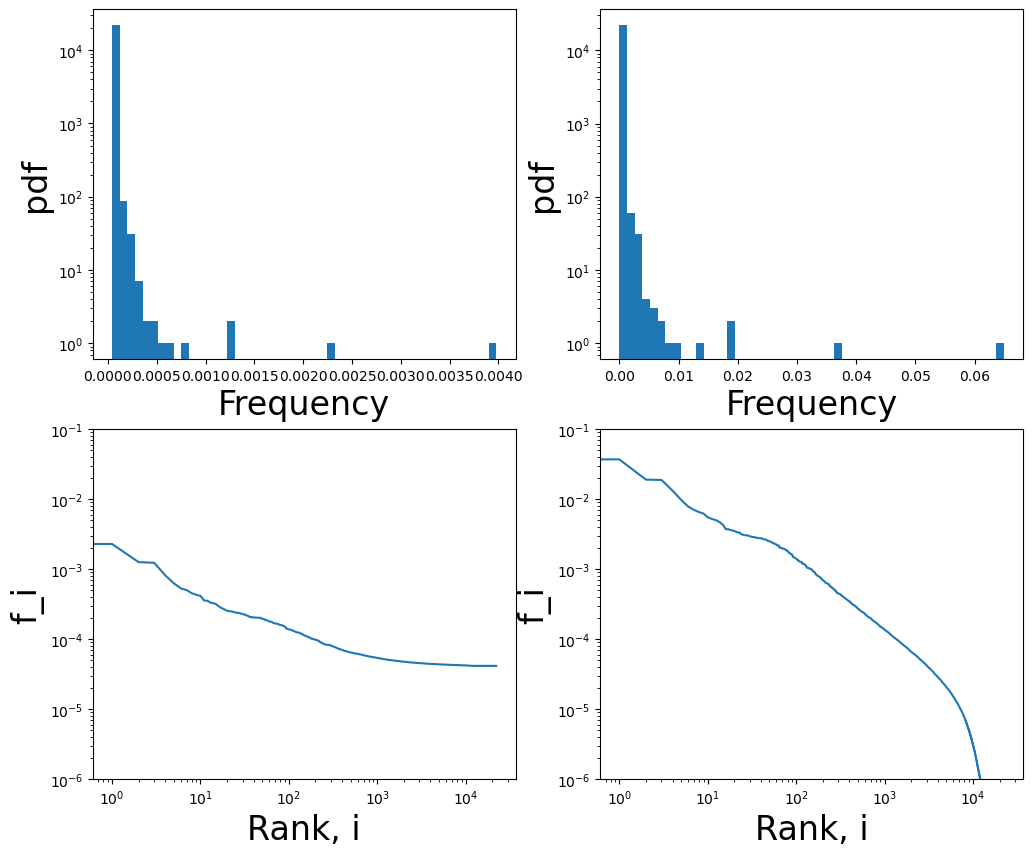

In [3]:
fig, ax = subplots(2,2, figsize=(12,10))
f = data["data"]["means_nonzero"].sort_values(ascending=false)

ax[1].hist(f/f.sum(),  bins=50)
ax[1].set_yscale("log")
ax[1].set_xlabel("Frequency", fontsize=24)
ax[1].set_ylabel("pdf", fontsize=24)

ax[2].plot(f/f.sum())
ax[2].set_xscale("log")
ax[2].set_yscale("log")
ax[2].set_ylim(1e-6,1e-1)
ax[2].set_xlabel("Rank, i", fontsize=24)
ax[2].set_ylabel("f_i", fontsize=24)


f = data["data"]["means"].sort_values(ascending=false)

ax[3].hist(f/f.sum(), bins=50)
ax[3].set_yscale("log")
ax[3].set_xlabel("Frequency", fontsize=24)
ax[3].set_ylabel("pdf", fontsize=24)

ax[4].plot(f/f.sum())
ax[4].set_xscale("log")
ax[4].set_yscale("log")
ax[4].set_ylim(1e-6,1e-1)
ax[4].set_xlabel("Rank, i", fontsize=24)
ax[4].set_ylabel("f_i", fontsize=24)
fig.savefig("f_distribution.pdf")
show()

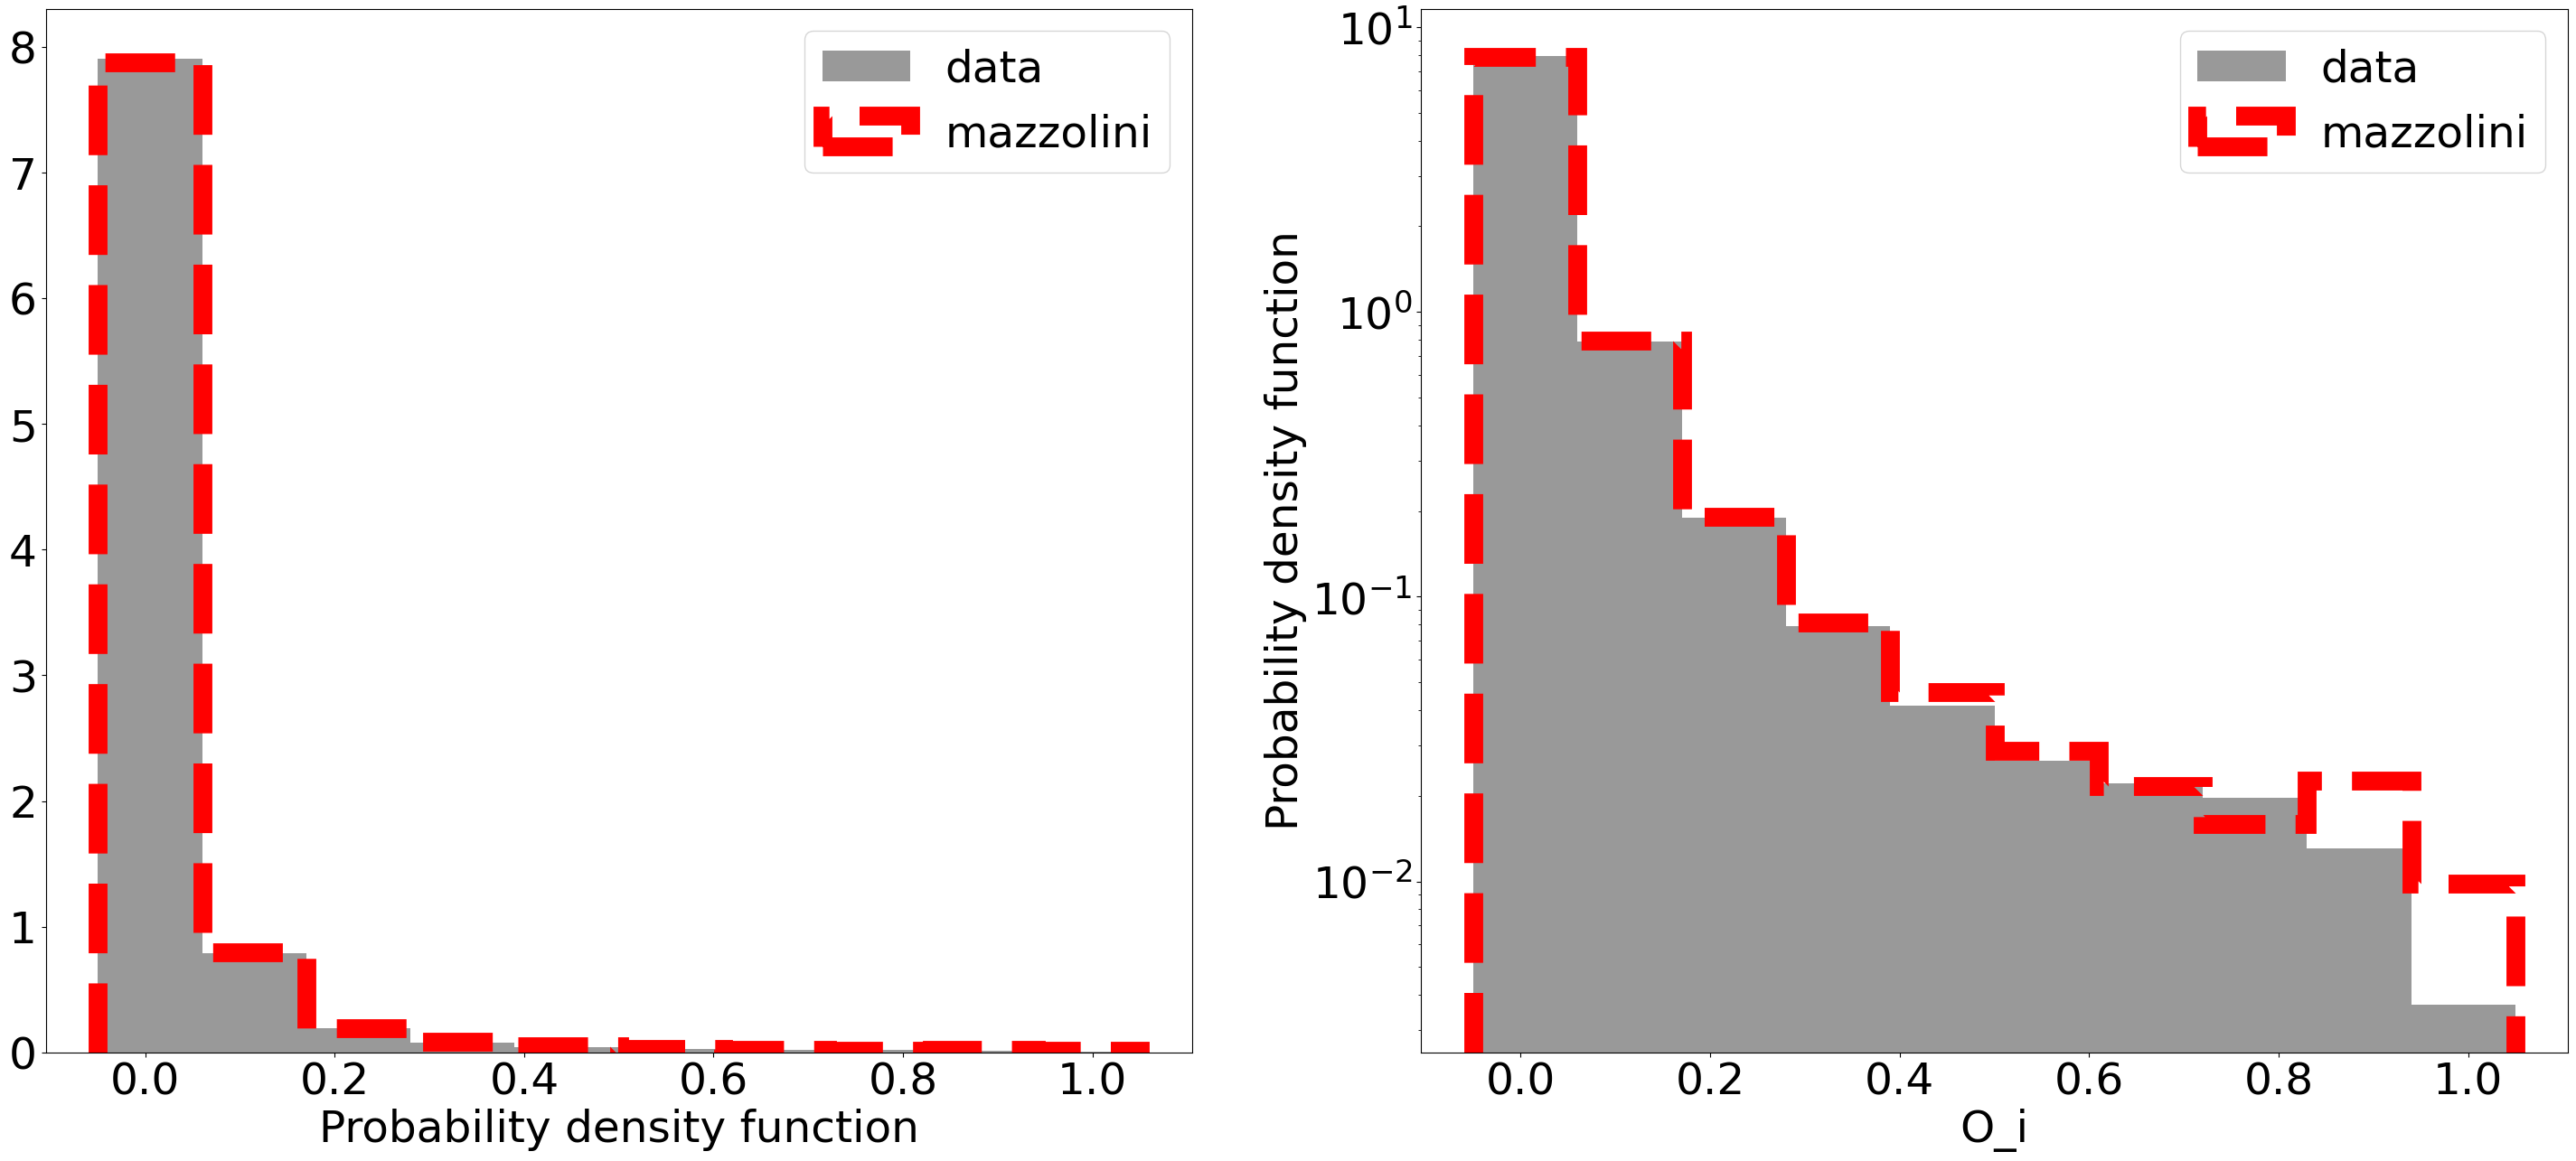

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [58]:
bins=10
rang = (0-0.5/bins, 1+0.5/bins)
fig, ax = subplots(1,2, figsize=(36,15))

ax[1].hist(data["data"]["O"], histtype="stepfilled", lw=15, color="gray", alpha=0.8, range=rang, bins=bins, label="data", density=true)
ax[1].hist(data["mazzolini"]["O"],histtype="step", lw=15, color="red",range=rang, bins=bins, ls="--", label="mazzolini", density=true)

ax[1].legend(fontsize=35)
ax[1].set_xlabel("O_i", fontsize=35)
ax[1].set_xlabel("Probability density function", fontsize=35)

ax[1].tick_params(labelsize=35)

ax[2].hist(data["data"]["O"],histtype="stepfilled", lw=15, color="gray", alpha=0.8, range=rang, bins=bins, label="data", density=true)
ax[2].hist(data["mazzolini"]["O"],histtype="step", lw=15, range=rang, bins=bins, color="red", ls="--", label="mazzolini", density=true)

ax[2].set_yscale("log")
ax[2].legend(fontsize=35)
ax[2].set_xlabel("O_i", fontsize=35)
ax[2].set_ylabel("Probability density function", fontsize=35)

ax[2].tick_params(labelsize=35)

fig.savefig("null_U.pdf")
fig.savefig("U_bone_mazzolini.eps")

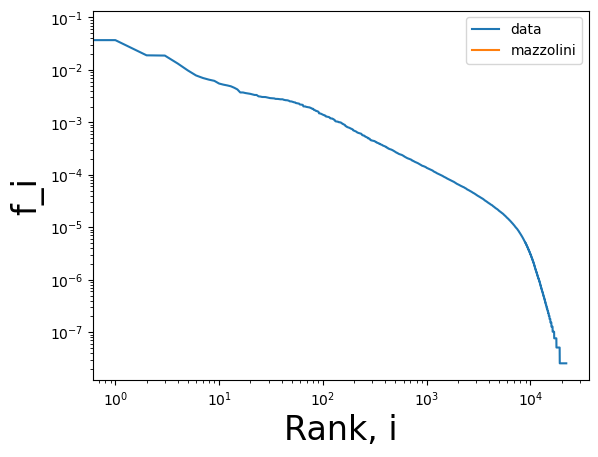

In [52]:
fig, ax = PyPlot.subplots()
ax.plot(sort!(data["data"]["freq"].values, rev=true), label="data")
ax.plot(sort!(data["mazzolini"]["freq"], rev=true)./sum(data["mazzolini"]["freq"]), label="mazzolini")

ax.legend()
ax.set_yscale("log")
ax.set_xscale("log")

ax.set_xlabel("Rank, i", fontsize=24)
ax.set_ylabel("f_i", fontsize=24)
show()

fig.savefig("null_zipf.pdf")

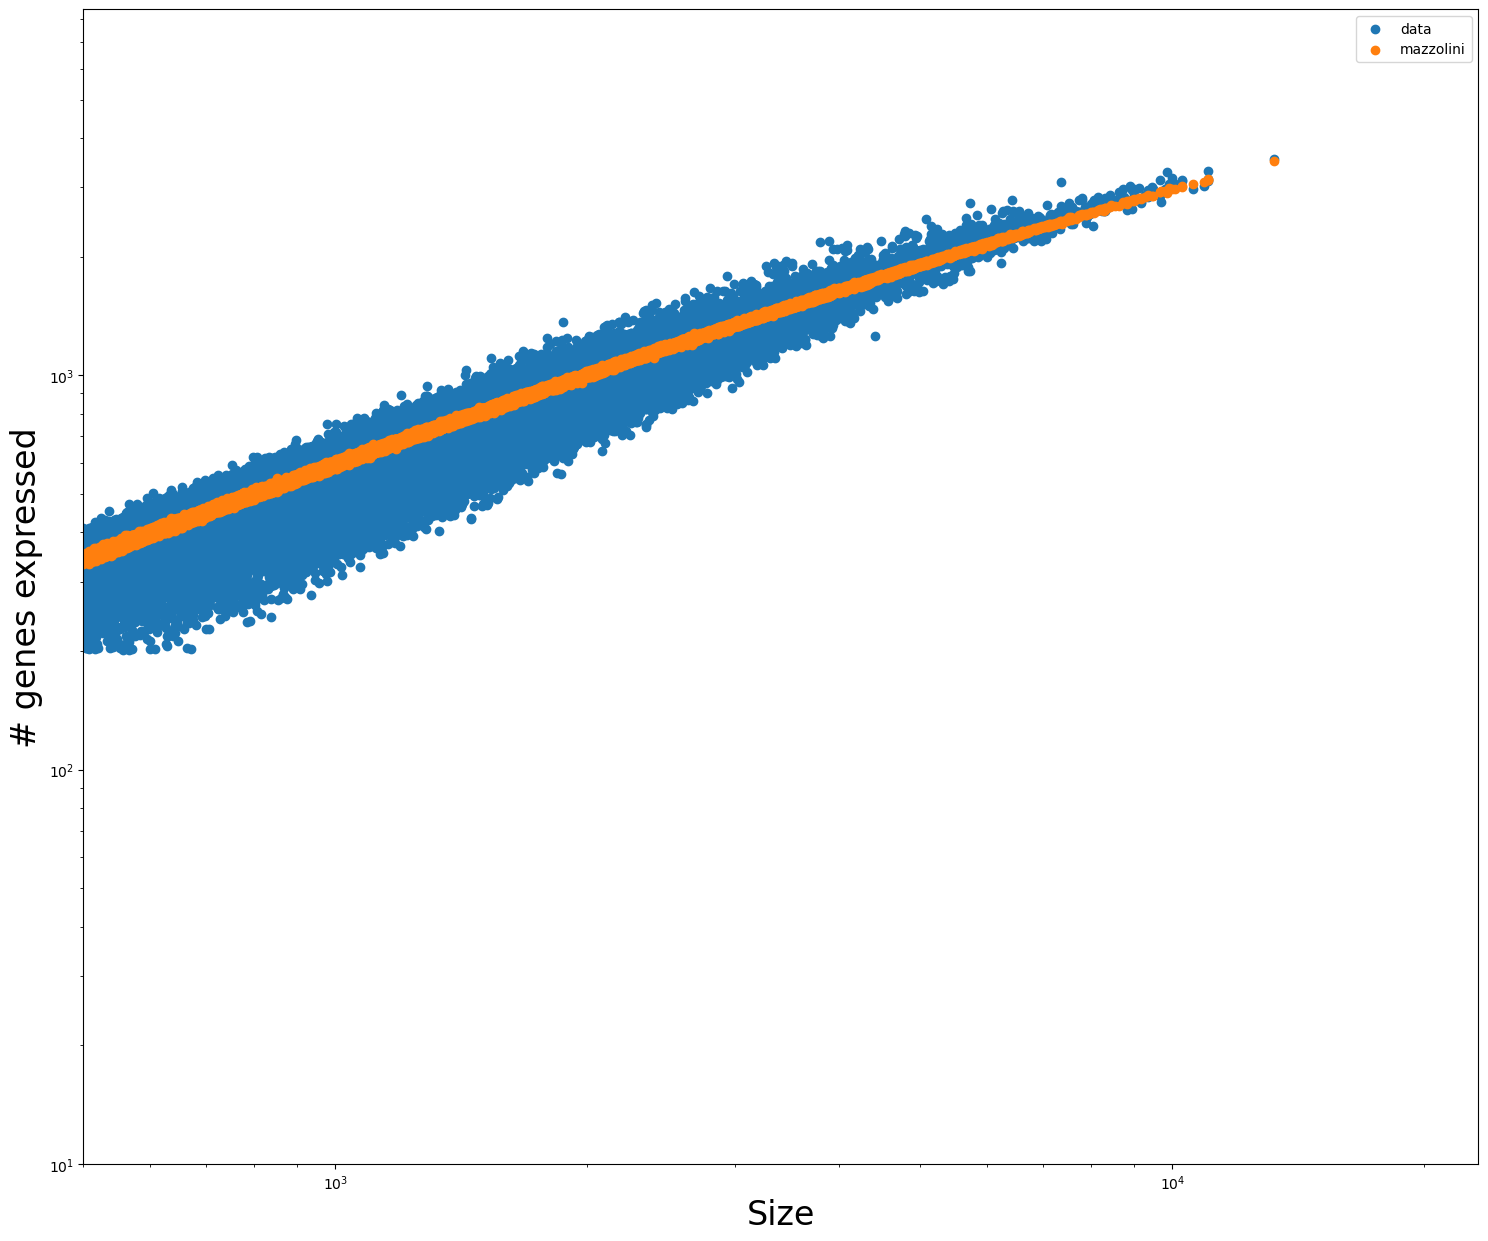

In [37]:
fig, ax = PyPlot.subplots(figsize=(18,15))
ax.scatter(data["data"]["M"], data["data"]["diffWords"], label="data")
ax.scatter(data["mazzolini"]["M"], data["mazzolini"]["diffWords"], label="mazzolini")


ax.legend()
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xlim(500,maximum(data["data"]["M"])+1e4)
ax.set_ylim(10,maximum(data["mazzolini"]["diffWords"])+5e3)

ax.set_xlabel("Size", fontsize=24)

ax.set_ylabel("# genes expressed", fontsize=24)
show()

fig.savefig("null_heaps.pdf")

## Bone-Marrow

### Heaps

In [ ]:
loglog=true

fig, ax = PyPlot.subplots(figsize=(18,15))

log_bins = [10^x for x in log10(minimum(data["data"]["M"].values)):0.1:log10(maximum(data["data"]["M"].values))]
ax.scatter(data["data"]["M"], data["data"]["diffWords"], c="gray", alpha=0.3, s=225, label="data")
bin_means, bin_edges = scipy_stats.binned_statistic(data["data"]["M"], data["data"]["diffWords"], bins=log_bins)

x_bins = (bin_edges[1:13] + bin_edges[2:14])/2
ax.plot(x_bins, bin_means[1:13], c="blue", alpha=0.9, lw=5, ms=25, marker="o", label="binned_data")


ax.set_xlabel("UMI per cell", fontsize=35)
ax.set_ylabel("Number of expressed genes", fontsize=35)

if loglog
    ax.set_xscale("log")
    ax.set_yscale("log")
end

ax.legend(fontsize=35)

ax.tick_params(labelsize=35, width=8, length=35)

PyPlot.show()
if loglog
    fig.savefig("heaps_boneMarrow_MCA_loglog.pdf")
    fig.savefig("heaps_boneMarrow_MCA_loglog.png", dpi=400)
else
    fig.savefig("heaps_boneMarrow_MCA.pdf")
    fig.savefig("heaps_boneMarrow_MCA.png", dpi=400)
end

In [ ]:
fig, ax = PyPlot.subplots(figsize=(18,15))

ax.scatter(data["data"]["M"], data["data"]["diffWords"], c="gray", alpha=0.3, s=225, label="data")
ax.scatter(data["mazzolini"]["M"], data["mazzolini"]["diffWords"], c="red", alpha=0.3, s=225, label="sampling model")

x_bins = (bin_edges[1:13] + bin_edges[2:14])/2
ax.plot(x_bins, bin_means[1:13], c="blue", alpha=0.9, ms=25, marker="o", label="binned_data")


ax.set_xlabel("UMI per cell", fontsize=35)
ax.set_ylabel("Number of expressed genes", fontsize=35)

ax.tick_params(labelsize=35, width=8, length=35)
ax.tick_params(which="minor", labelsize=35, width=5, length=25)


if loglog
    ax.set_xscale("log")
    ax.set_yscale("log")
end

ax.legend(fontsize=35)

PyPlot.show()
if loglog
    fig.savefig("heaps_boneMarrow_sampling_MCA_loglog.pdf")
    fig.savefig("heaps_boneMarrow_sampling_MCA_loglog.png", dpi=400)
else
    fig.savefig("heaps_boneMarrow_sampling_MCA.pdf")
    fig.savefig("heaps_boneMarrow_sampling_MCA.png", dpi=400)
end

### U

In [ ]:
100/length(data["data"]["M"])

In [61]:
fig, ax = PyPlot.subplots(figsize=(18,15))

density=true

bins = [10^x for x in range(log10(3e-5), log10(1.05), length=10)]
#bins = 0.003:0.05:1.05
bin_counts, bin_edges = ax.hist(data["data"]["O"].values[data["data"]["O"].index.isin(CSV.read("tm/FACS/Aorta-counts.csv").Column1)], color="gray", lw=10, histtype="step", bins=bins, density=density)

x_bins = (bin_edges[1:length(bin_edges)-1]+bin_edges[2:length(bin_edges)])/2
ax.hist(x_bins, weights=bin_counts, bins=bins, histtype="stepfilled", color="gray", lw=0, alpha=0.3)

bin_counts, bin_edges = ax.hist(data["mazzolini"]["O"].dropna(), color="red", lw=10, histtype="step", bins=bins, density=density)


ax.set_xlabel(L"Occurrence, O_i", fontsize=35)
ax.set_ylabel("Number of genes", fontsize=35)

ax.tick_params(labelsize=35, width=8, length=20)
ax.tick_params(which="minor", width=6, length=10)

ax.set_yscale("log")
ax.set_xscale("log")

PyPlot.show()
fig.savefig("U_$(tissue)_mca.pdf")

ErrorException: type Array has no field dropna

# Count Zeros

In [ ]:
data = load_pickle("mca/data_all.pkl")
data["O"].sum()*length(data["M"])

In [ ]:
1-mean(data["O"].values[data["O"].values .> 0])

In [ ]:
length(data["M"].dropna())